In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics import mean_squared_error
from helpers_pmf import *

In [92]:
mu = 0.0 
sigma_u = 1.0
sigma_v = 1.0
sigma = 0.2 
parameters = {}
d_dims = 2 

__generate__ matrices U, V and R from Gauss. distributions

In [93]:
def generate_U_V_R(mu, sigma_U, sigma_V, sigma, n_users, n_movies):
    U = np.random.normal(mu, sigma_U, size=(d_dims,n_users))
    V = np.random.normal(mu, sigma_V, size=(d_dims,n_movies))
    noise = np.random.normal(mu, sigma, size=(n_users,n_movies)) 
    R = np.matmul(U.T,V) +noise
    return U, V, R

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [94]:
def initialize_parameters(sigma_U, sigma_V, mu, sigma, n_users, n_movies):    
    U, V, R = generate_U_V_R(mu, sigma_U, sigma_V, sigma, n_users, n_movies) 
    U_init = np.random.normal(mu, sigma_U, (d_dims, n_users))
    V_init = np.random.normal(mu, sigma_V, (d_dims, n_movies))    
    parameters['U'] = U
    parameters['V'] = V
    parameters['R'] = R
    parameters['U_result'] = U_init
    parameters['V_result'] = V_init
    parameters['lambda_U'] = sigma**2/sigma_U**2
    parameters['lambda_V'] = sigma**2/sigma_V**2

create __ratings__ dataframe and append rating matrix

In [95]:
def create_rating_df(n_users, n_movies):   
    initialize_parameters(sigma_u/sigma, sigma_v/sigma, mu, sigma, n_users, n_movies)
    
    df = pd.DataFrame(columns=['userID', 'movieID'])
    df['userID'] = np.repeat(np.arange(1, n_users+1, 1), n_movies)
    df['movieID'] = np.tile(np.arange(1, n_movies+1, 1), n_users) 
    
    R = parameters['R']
    df['rating'] = R.reshape(n_users*n_movies)
    


Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [97]:
def update_parameters(n_users, n_movies):
    U = parameters['U_result']
    V = parameters['V_result']
    R = parameters['R']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']

    for i in range(n_users):
        RV = R[i] @ V.T
        Vinv = np.linalg.inv(np.dot(V,V.T) + lambda_U * np.identity(d_dims))
        U[:, i] =  Vinv @ RV 
        
    for j in range(n_movies):
        RU = R[:, j] @ U.T
        Uinv = np.linalg.inv(np.dot(U, U.T) + lambda_V * np.identity(d_dims))
        V[:, j] = Uinv @ RU
 
    parameters['U_result'] = U
    parameters['V_result'] = V

Now let's implement the __Log-a posteriori__:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [98]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    R = parameters['R']
    UV = np.dot(U_result.T, V_result)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U_result, U_result.T)) + \
                   lambda_V * np.sum(np.dot(V_result, V_result.T)))


For the purposes of __scaling__, we need the maximum and minimum rating values.

In [99]:
def update_max_min_ratings():
    U = parameters['U_result']
    V = parameters['V_result']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [100]:
def predict(user_id, movie_id):
    U = parameters['U_result']
    V = parameters['V_result']
    r_ij = U[:, user_id-1].T.reshape(1, -1) @ V[:, movie_id-1].reshape(-1, 1) 
    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

We implement both the __Frobenius__ and __orthogonal Procrustes__ norms

In [101]:
def frob(X, Y, N):
    return np.linalg.norm(X - Y, 'fro')/np.sqrt(N)

In [102]:
#add more comments for each cell, provide links/resources 
def orth_procrustes(X, Y, len_X):
    R, scale = orthogonal_procrustes(X, Y)
    rss = np.linalg.norm(X @ R - Y, 'fro')/np.sqrt(len_X)
    
    return rss

The __compare_results__ function will calculate the Frobenius/ Orthogonal Procrustes __norm difference__ of the resulting U and V matrices with the initial ones

In [108]:
def compare_results(n_users, n_movies):
    U = parameters['U']
    V = parameters['V']
    R = parameters['R']

    U_result = parameters['U_result']
    V_result = parameters['V_result']
    R_result = U_result.T @ V_result
    
    diff_norm_U = orth_procrustes(U, U_result, n_users)     
    diff_norm_V = orth_procrustes(V, V_result, n_movies) 
    diff_norm_R = frob(R, R_result , n_movies*n_users) 
    return diff_norm_R, diff_norm_U, diff_norm_V


The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [110]:
def train( n_users, n_movies):
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    k = 0
    while True:
        if len(log_aps) > 2:
            if np.abs(log_aps[-1] - log_aps[-2]) < 0.0001:
                break
        update_parameters(n_users, n_movies)
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)
        k += 1
        if (k + 1) % 25 == 0: #10
            update_max_min_ratings()

    update_max_min_ratings()
    diff_norm_R, diff_norm_U, diff_norm_V = compare_results(n_users, n_movies)
    return log_aps, rmse_train, rmse_test, diff_norm_R, diff_norm_U, diff_norm_V

Let's train our model!

In [111]:
def avg_results(N_val, M_val, nb_iter):
        avg_U = 0
        avg_V = 0
        avg_R = 0
        avg_log_aps = []
        
        for i in range(nb_iter):
            create_rating_df(N_val, M_val)
            log_aps, _, _, diff_R, diff_U, diff_V = train(N_val, M_val)   
 
            avg_U += diff_U
            avg_V += diff_V
            avg_R += diff_R
            avg_log_aps.append(log_aps)
            
        avg_U /= nb_iter
        avg_V /= nb_iter
        avg_R /= nb_iter
        
        return avg_R, avg_U, avg_V

In [112]:
N_vals = [10, 20, 30, 40, 50]#, 100]
M_vals = [10, 20, 30, 40, 50]
nb_iter = 10
data = []
np.set_printoptions(precision = 6)
print(sigma_u, sigma_v, sigma)
for i in range(len(N_vals)):
    for j in range(len(M_vals)):
        print(f'i,j:{i},{j}') # 
        avg_R, avg_U, avg_V = avg_results(N_vals[i], M_vals[j], nb_iter)
        row= [N_vals[i], M_vals[j], avg_R, avg_U, avg_V]
        print(row) # to check progress
        data.append(row)       

1.0 1.0 0.2
i,j:0,0
[10, 10, 0.16284052663654683, 3.171132975216712, 11.47547645226556]
i,j:0,1
[10, 20, 0.1646987899755174, 3.7087417665506046, 6.389160721301534]
i,j:0,2
[10, 30, 0.17163830290824034, 2.99754168202042, 4.909131729864674]
i,j:0,3
[10, 40, 0.17293094711762377, 3.1101477544989264, 5.144389223474883]
i,j:0,4
[10, 50, 0.1718041789483465, 2.739924770886712, 4.0422776950507275]
i,j:1,0
[20, 10, 0.17324425097638024, 3.9044993780911574, 11.096876854437244]
i,j:1,1
[20, 20, 0.17992967864855264, 3.4013269700922413, 12.356899664586106]
i,j:1,2
[20, 30, 0.183443574726261, 3.707542286762023, 6.9259933180702316]
i,j:1,3
[20, 40, 0.18335693214601492, 3.4019777283364023, 6.019448975742713]
i,j:1,4
[20, 50, 0.1848469410359611, 3.009546564790056, 5.027876631015653]
i,j:2,0
[30, 10, 0.17695859272346964, 4.381836562564162, 18.83365503791462]
i,j:2,1
[30, 20, 0.1823268124286319, 4.108718249172657, 16.26715808618816]
i,j:2,2
[30, 30, 0.18537339662058605, 3.8537963329807225, 8.66248567742191

In [113]:
data[:50]

[[10, 10, 0.16284052663654683, 3.171132975216712, 11.47547645226556],
 [10, 20, 0.1646987899755174, 3.7087417665506046, 6.389160721301534],
 [10, 30, 0.17163830290824034, 2.99754168202042, 4.909131729864674],
 [10, 40, 0.17293094711762377, 3.1101477544989264, 5.144389223474883],
 [10, 50, 0.1718041789483465, 2.739924770886712, 4.0422776950507275],
 [20, 10, 0.17324425097638024, 3.9044993780911574, 11.096876854437244],
 [20, 20, 0.17992967864855264, 3.4013269700922413, 12.356899664586106],
 [20, 30, 0.183443574726261, 3.707542286762023, 6.9259933180702316],
 [20, 40, 0.18335693214601492, 3.4019777283364023, 6.019448975742713],
 [20, 50, 0.1848469410359611, 3.009546564790056, 5.027876631015653],
 [30, 10, 0.17695859272346964, 4.381836562564162, 18.83365503791462],
 [30, 20, 0.1823268124286319, 4.108718249172657, 16.26715808618816],
 [30, 30, 0.18537339662058605, 3.8537963329807225, 8.662485677421913],
 [30, 40, 0.18905699026229703, 3.7723559573062517, 8.102909278180388],
 [30, 50, 0.1898

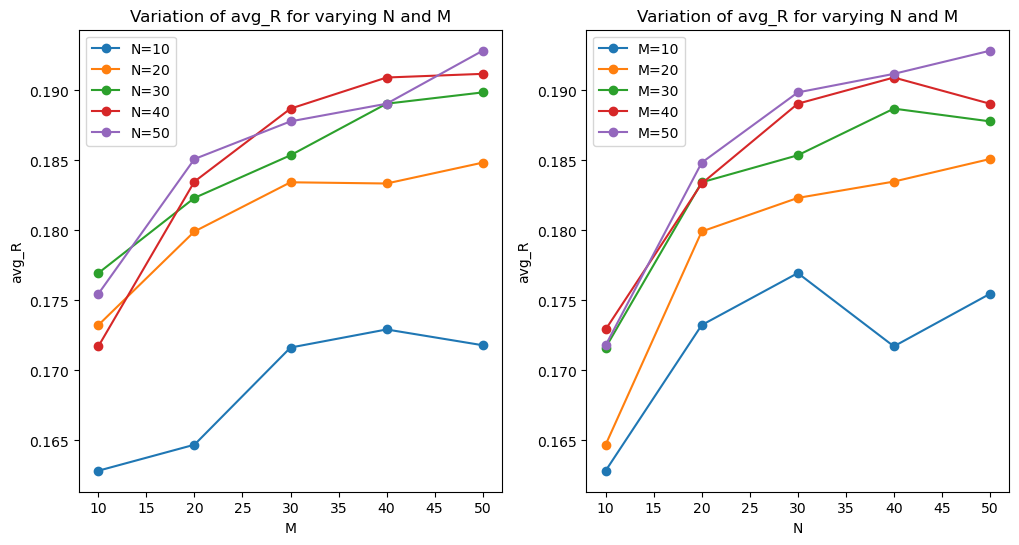

In [114]:
# plot as a function of M for avg_U and as a function of N fro avg_V
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_R', 'avg_U', 'avg_V'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_R'], marker='o', label=f'N={n}')

for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_R'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_R')
ax1.set_title('Variation of avg_R for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_R')
ax2.set_title('Variation of avg_R for varying N and M')
ax2.legend()

plt.show()

In [115]:
fig.savefig('avg_PMF_R.png')

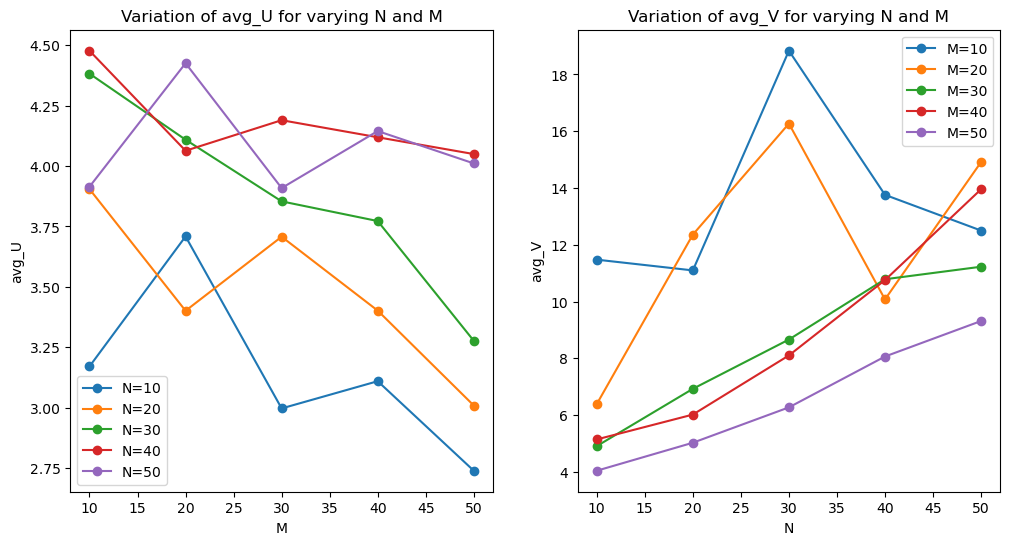

In [116]:
# plot as a function of M for avg_U and as a function of N for avg_V

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U'], marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()

In [117]:
fig.savefig('avg_PMF_U_V.png')